<a href="https://colab.research.google.com/github/satogen/googleEarthEngineScripts/blob/main/grid_img_downloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Earth Engine Python APIのインポート
import ee
# GEEの認証・初期化
ee.Authenticate()
ee.Initialize()
from google.colab import drive
drive.mount('/content/drive')

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=3jTDqeuEw8J9dWzRwz0fOeUqV671yvuxJHb8L5nnEmc&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhIQHnKtyclL4l9fcEoE1jhOFdnkKeY3vLRVSYeY-cFPubNRqidNRs

Successfully saved authorization token.
Mounted at /content/drive


## ポリゴンデータからグリッド上に分割し、ダウンロードをする

### 参考サイト
GEE公式チュートリアルより、関数等を引用

https://developers.google.com/earth-engine/tutorials/community/drawing-tools


### データセット
Google Earth EngineのDEMデータセット

https://developers.google.com/earth-engine/datasets/tags/dem


In [ ]:
class CFG:
  geometry = ee.Geometry.Polygon(
      [[[137.075832631131, 36.443696383744054],
          [137.075832631131, 35.36249647967924],
          [138.7292750139435, 35.36249647967924],
          [138.7292750139435, 36.443696383744054]]])
  SAVE_DRIVE_FOLDER = 'GIS'
  SCALE = 30

  # target_satellite =  'USGS/GMTED2010'
  # target_band = 'be75'
  target_satellite =  'NASA/NASADEM_HGT/001'
  target_band = 'elevation'

In [ ]:
def makeGrid(geometry, scale):
  lonLat = ee.Image.pixelLonLat();

  lonGrid = lonLat.select('longitude').multiply(10000000).toInt()

  latGrid = lonLat.select('latitude').multiply(10000000).toInt()

  return lonGrid.multiply(latGrid).reduceToVectors(**{
      'geometry': geometry, 
      'scale': scale,
      'geometryType': 'polygon',
    })
  

def create_liner_ring(feature):
    featureGeometry = ee.Feature(feature).geometry();
    # print(featureGeometry.coordinates())
    return ee.Geometry.Polygon(featureGeometry.coordinates())
    # coordinates = featureGeometry.coordinates().get(0);
    # return ee.Geometry.LinearRing(coordinates)

def buildGeometryList(grid, limit):
  return grid.toList(limit).map(create_liner_ring)


def export_table(table, description, target_region):
  task = ee.batch.Export.table.toDrive(**{ 
    'collection': ee.FeatureCollection(table), 
    'description': description,
    'folder':CFG.OUT_PUTPATH, 
    'selectors':(CFG.target_col),
    'region': target_region
  })
  if CFG.PRODUCTION:
    task.start()
  print(f'export {description} file complete!')


def save_image(dataset_image, file_name, polygon, save_folder=CFG.SAVE_DRIVE_FOLDER, scale=CFG.SCALE):
  """
  画像の保存をする

  Parameters
  ----------
  file_name : str
      ファイルの名前
  polygon : ee.geometry.Geometry
      ポリゴンデータ
  save_path : str
      保存対象のパス
  scale : int
      画像のスケール
  """
  # Gdriveへ保存
  task = ee.batch.Export.image.toDrive(**{
      'image': dataset_image,
      'description': file_name,
      'folder':save_folder, # 
      'scale': scale,
      'region': polygon
  })

  # 処理の実行
  task.start()

## グリッドの作成

In [ ]:
grid = makeGrid(CFG.geometry, 10000); # 10km

In [ ]:
geometries = buildGeometryList(grid, 1000)

In [ ]:
print(f'grid数：{grid.size().getInfo()}')

grid数：216


In [ ]:
print(geometries.getInfo())

[{'type': 'Polygon', 'coordinates': [[[137.08291235663899, 35.393622194309145], [137.17274388505092, 35.393622194309145], [137.17274388505092, 35.483453722721094], [137.08291235663899, 35.483453722721094], [137.08291235663899, 35.393622194309145]]]}, {'type': 'Polygon', 'coordinates': [[[137.08291235663899, 35.483453722721094], [137.17274388505092, 35.483453722721094], [137.17274388505092, 35.57328525113305], [137.08291235663899, 35.57328525113305], [137.08291235663899, 35.483453722721094]]]}, {'type': 'Polygon', 'coordinates': [[[137.08291235663899, 35.57328525113305], [137.17274388505092, 35.57328525113305], [137.17274388505092, 35.663116779545], [137.08291235663899, 35.663116779545], [137.08291235663899, 35.57328525113305]]]}, {'type': 'Polygon', 'coordinates': [[[137.08291235663899, 35.663116779545], [137.17274388505092, 35.663116779545], [137.17274388505092, 35.752948307956956], [137.08291235663899, 35.752948307956956], [137.08291235663899, 35.663116779545]]]}, {'type': 'Polygon',

## データセットの選択

In [ ]:
# # データセットの選択
# # 日付を決定する
# dataset = ee.ImageCollection(CFG.target_satellite).first()

# # 対象バンドの選択
# select_dataset = dataset.select(CFG.target_band)


dataset = ee.Image(CFG.target_satellite);
select_dataset = dataset.select(CFG.target_band);

## DEMのダウンロード

In [ ]:
for i in range(grid.size().getInfo()):
  polygon = ee.Geometry.Polygon(ee.Feature(geometries.get(i)).geometry().getInfo()['coordinates'])
  save_image(select_dataset, str(i) + '_DEM' , polygon)

In [ ]:
# t_poky = ee.Geometry.Polygon(grid.get(0).getInfo()['coordinates'])
# save_image(select_dataset, 'test_dem', t_poky)

In [ ]:
print(ee.Feature(geometries.get(0)).geometry().getInfo()['coordinates'])

[[[-118.03862833330513, 37.369915819372096], [-117.94879680489316, 37.369915819372096], [-117.94879680489316, 37.459747347784045], [-118.03862833330513, 37.459747347784045], [-118.03862833330513, 37.369915819372096]]]


## データの確認

In [ ]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 46.0 MB/s 


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import os
import pandas as pd

(1, 168, 168)


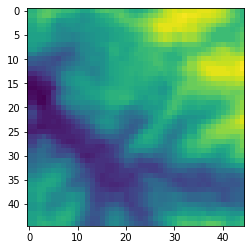

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
%matplotlib inline

# データの読み込み
with rasterio.open('/content/drive/MyDrive/GIS/0_DEM.tif') as src:
    arr = src.read()

#  numpy形式でデータを取得 -> (1, 1847, 2208)の配列で取得
print(arr.shape)

# 可視化
plt.imshow(arr[0][:45, :45])